# 8,000 Line Segments

Author - Andrew Ferguson

The work in this notebook is based on the artwork created by Hamid Naderi Yeganeh.

The original work can be found at https://blogs.scientificamerican.com/guest-blog/making-mathematical-art/.

This notebook features the design from the above source entitled 8,000 Line Segments.

This design is a hardware accelerated model designed to be run on the PYNQ-Z2 board.

Firstly, import the necessary libraries.

In [1]:
import matplotlib.pyplot as plt
import math

The values that will be recieved back via the AXI-Lite interface from the PYNQ-Z2 board will be 32 bits in length. Python recognises these as 32 bit unsigned numbers. The following function is used to convert these to signed binary numbers with 1 sign bit, 1 integer bit and 30 fractional bits.

In [2]:
def to_signedfract_2(val,b):
    val_str = (bin(val)[2:]).zfill(b);
    return -1*int(val_str[0])*2 + int(val_str[1]) + int(val_str[2:], 2) / 2.** (b-2)

This design involves plotting 8,000 line segments. For each value of k = 1,2,3,...,8000 the startpoint of each line segment is given by [A(k),B(k)] and the endpoint of each line segment is given by [C(k),D(k)]. These are described by the following formulas.

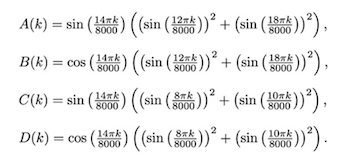

The computation to calculate the start and end points of each line segment is carried out in the programmable logic of the PYNQ-Z2 board. The design for this was realised using system generator to generate the IP core and IP interface document. The block diagram in system generator is shown below.

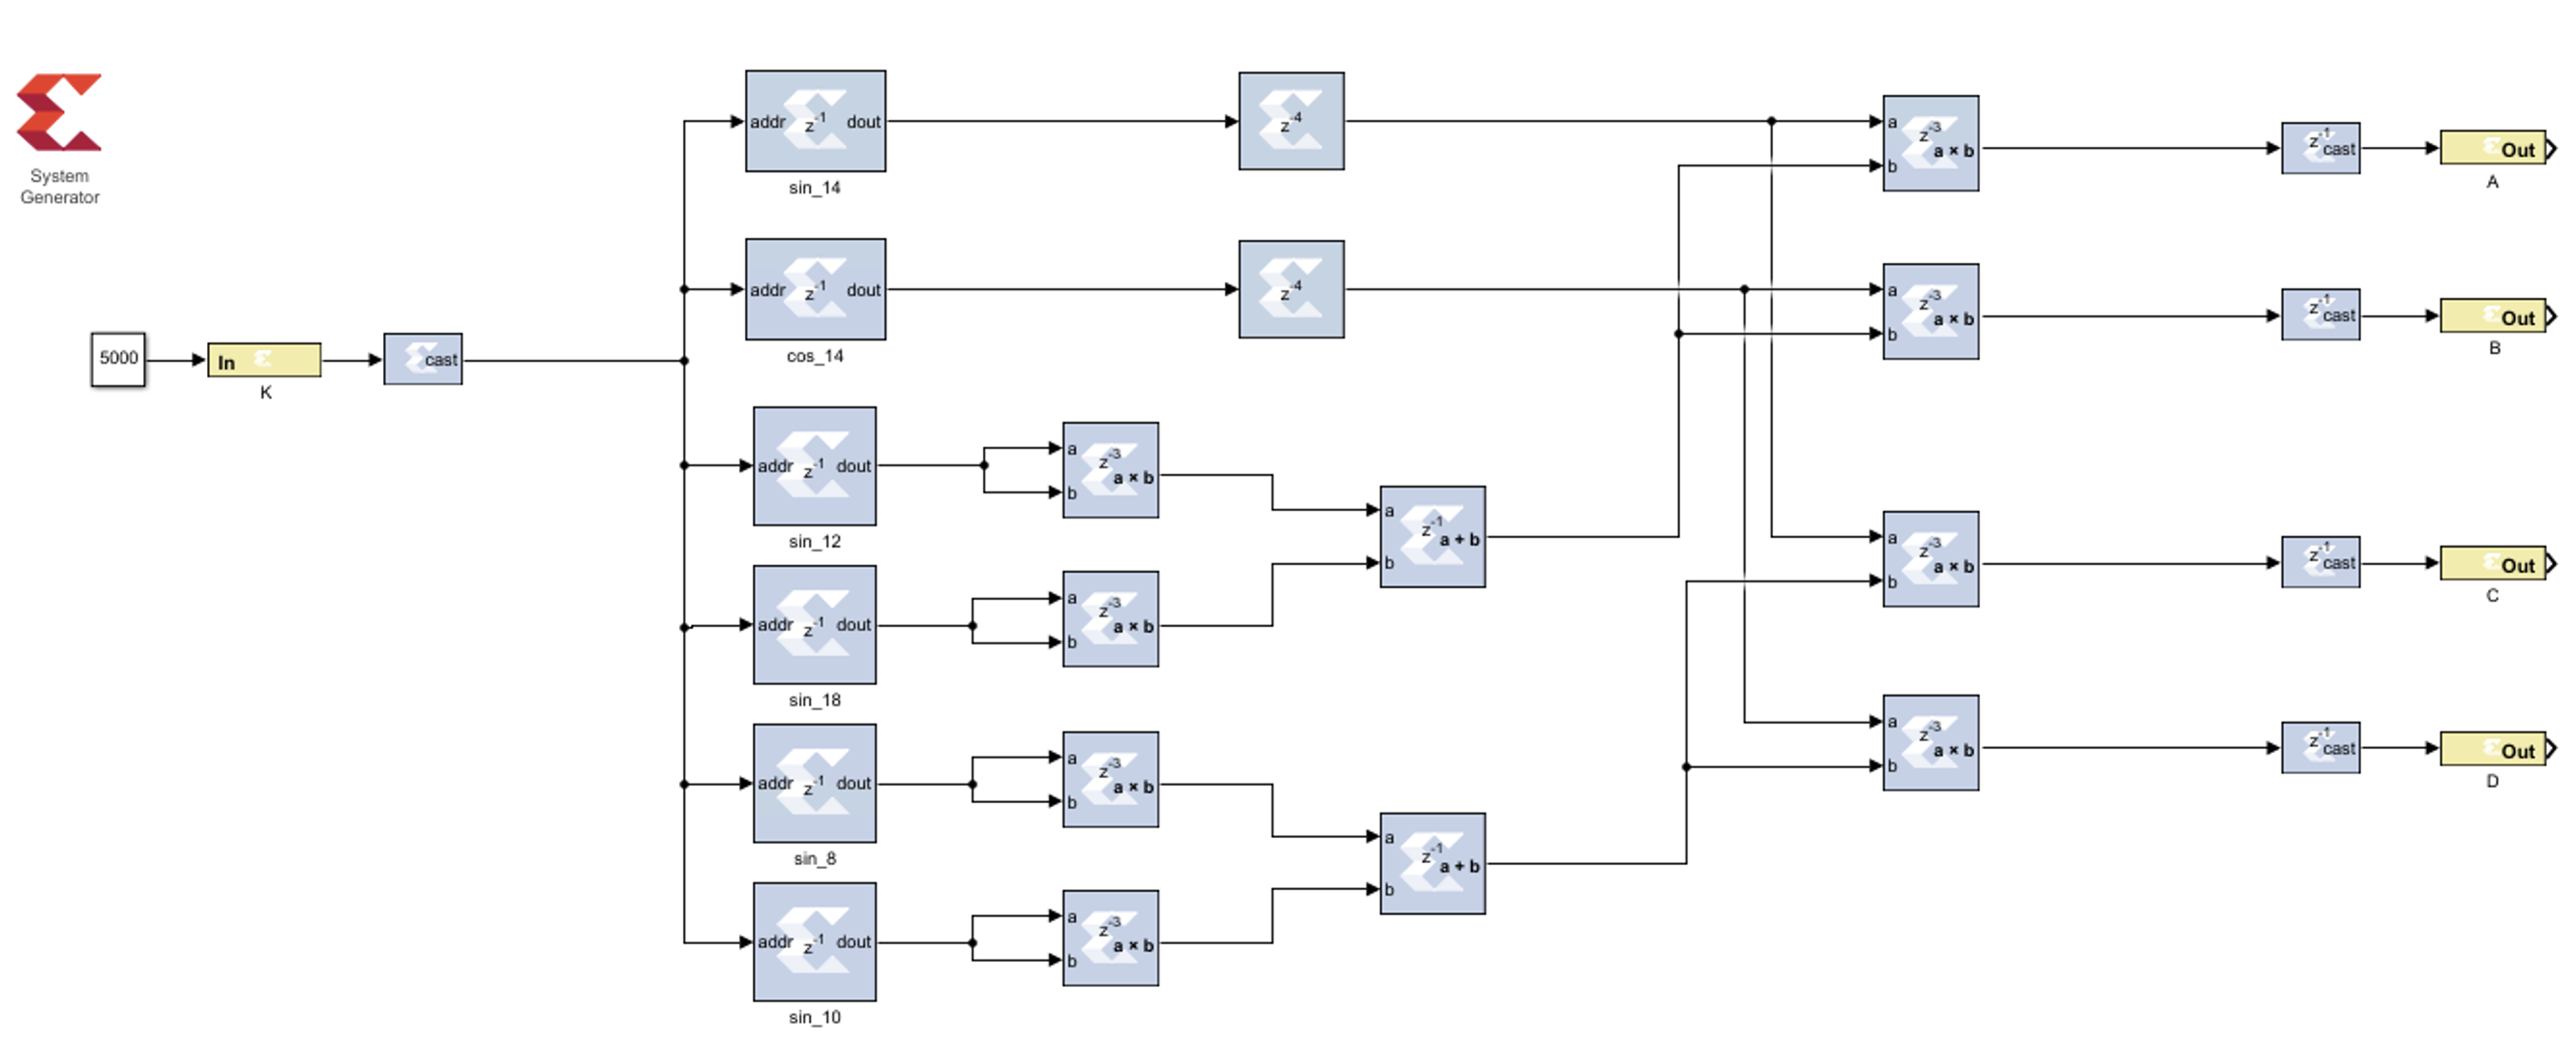

All the sine and cosine values are stored in lookup tables. These are addressed by the input variable k. The values obtained then go through the necessary computation of multiplication and addition/subtraction to achieve the functionality described in the above equations. Delay blocks are include to ensure equal path length between branches.

Vivado was then used to create the custom overlay using the IP from system generator. This created the following block diagram.

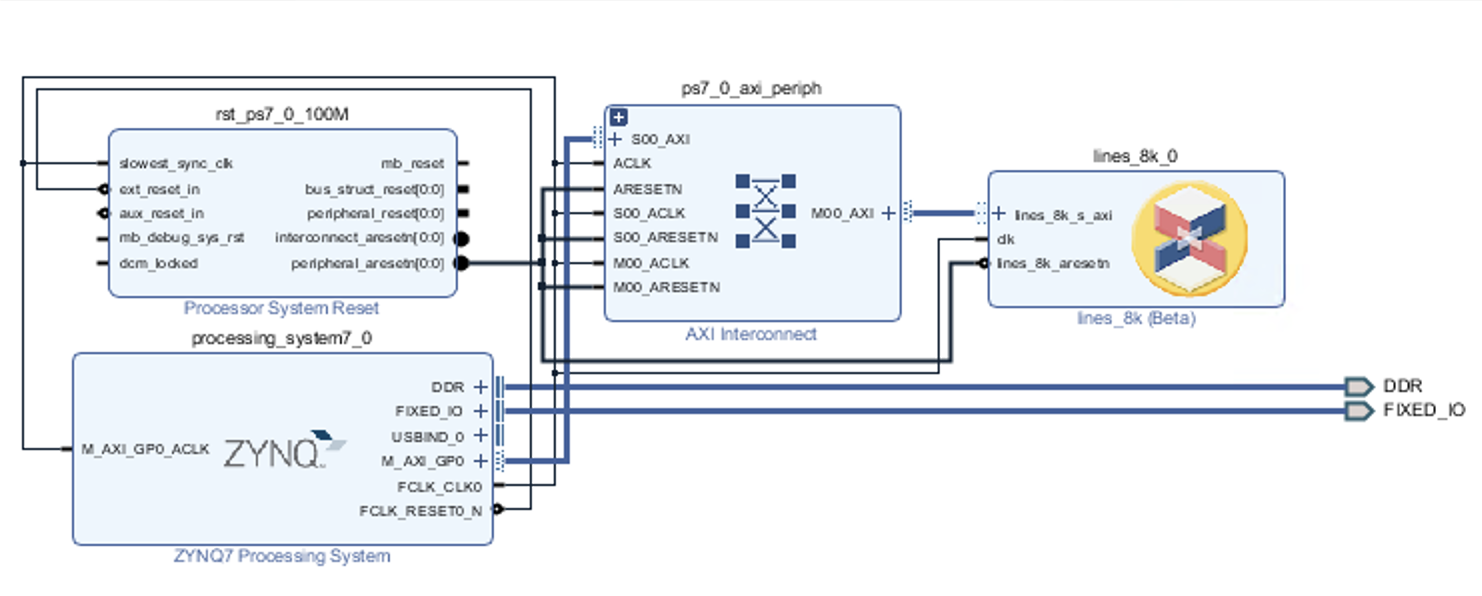

This was then used to generate the hardware handoff file and the bit file for the design, which are include in this project folder. The following code then declares a custom driver for the IP. This allows the processing system to read and write to the programmable logic efficiently.

In [5]:
from pynq import DefaultIP
class AddDriver(DefaultIP):
    def __init__(self, description):
        super().__init__(description=description)
    bindto = ['User_Company:SysGen:lines_8k:1.0']
    def getA(self, k):
        self.write(0x00, k) 
        return to_signedfract_2(self.read(0x8),32)
    
    def getB(self, k):
        self.write(0x00, k) 
        return to_signedfract_2(self.read(0x04),32) 
    
    def getC(self, k):
        self.write(0x00, k) 
        return to_signedfract_2(self.read(0x0C),32)
    
    def getD(self, k):
        self.write(0x00, k) 
        return to_signedfract_2(self.read(0x10),32)
    
    def getValues(self,k):
        self.write(0x00, k)
        return to_signedfract_2(self.read(0x8),32),to_signedfract_2(self.read(0x04),32),to_signedfract_2(self.read(0x0C),32),to_signedfract_2(self.read(0x10),32)

The custom overlay is then imported.

In [6]:
from pynq import Overlay
ol = Overlay("design_1_wrapper.bit");

In [7]:
lines_8k = ol.lines_8k_0

The following function obtains the line start and end points and plots the corresponding lines on a graph. The colour of the line segments is gradually changed throughout the loop iteration. PuBuGn and BuPu colour codes are used here. Feel free to change these before you call the function. The following colour code options are available:

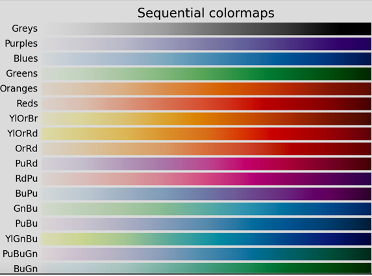

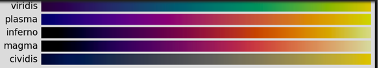

In [1]:
def plot_values():
    figure, axes = plt.subplots(dpi = 600)
    A,B,C,D = 0,0,0,0
    for i in range(1, 8000):
        
        if i <= 4000:
            #COLOUR CODE CHANGE
            colour_grad = plt.cm.PuBuGn (i/4000)
        else:
            #COLOUR CODE CHANGE
            colour_grad = plt.cm.BuPu((i-4000)/4000)
        A,B,C,D = lines_8k.getValues(i)   
        axes.plot([A,C], [B,D], color=colour_grad, linewidth=0.1)


    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    axes.axis('off')
    axes.set_aspect(1)


    plt.show()

Call the function. Please be aware the run time for the function is about 5 mins due to the demanding nature of plotting 8,000 line segments using the PYNQ-Z2 processor. You can reduce the dpi in the above function to marginally reduce this.

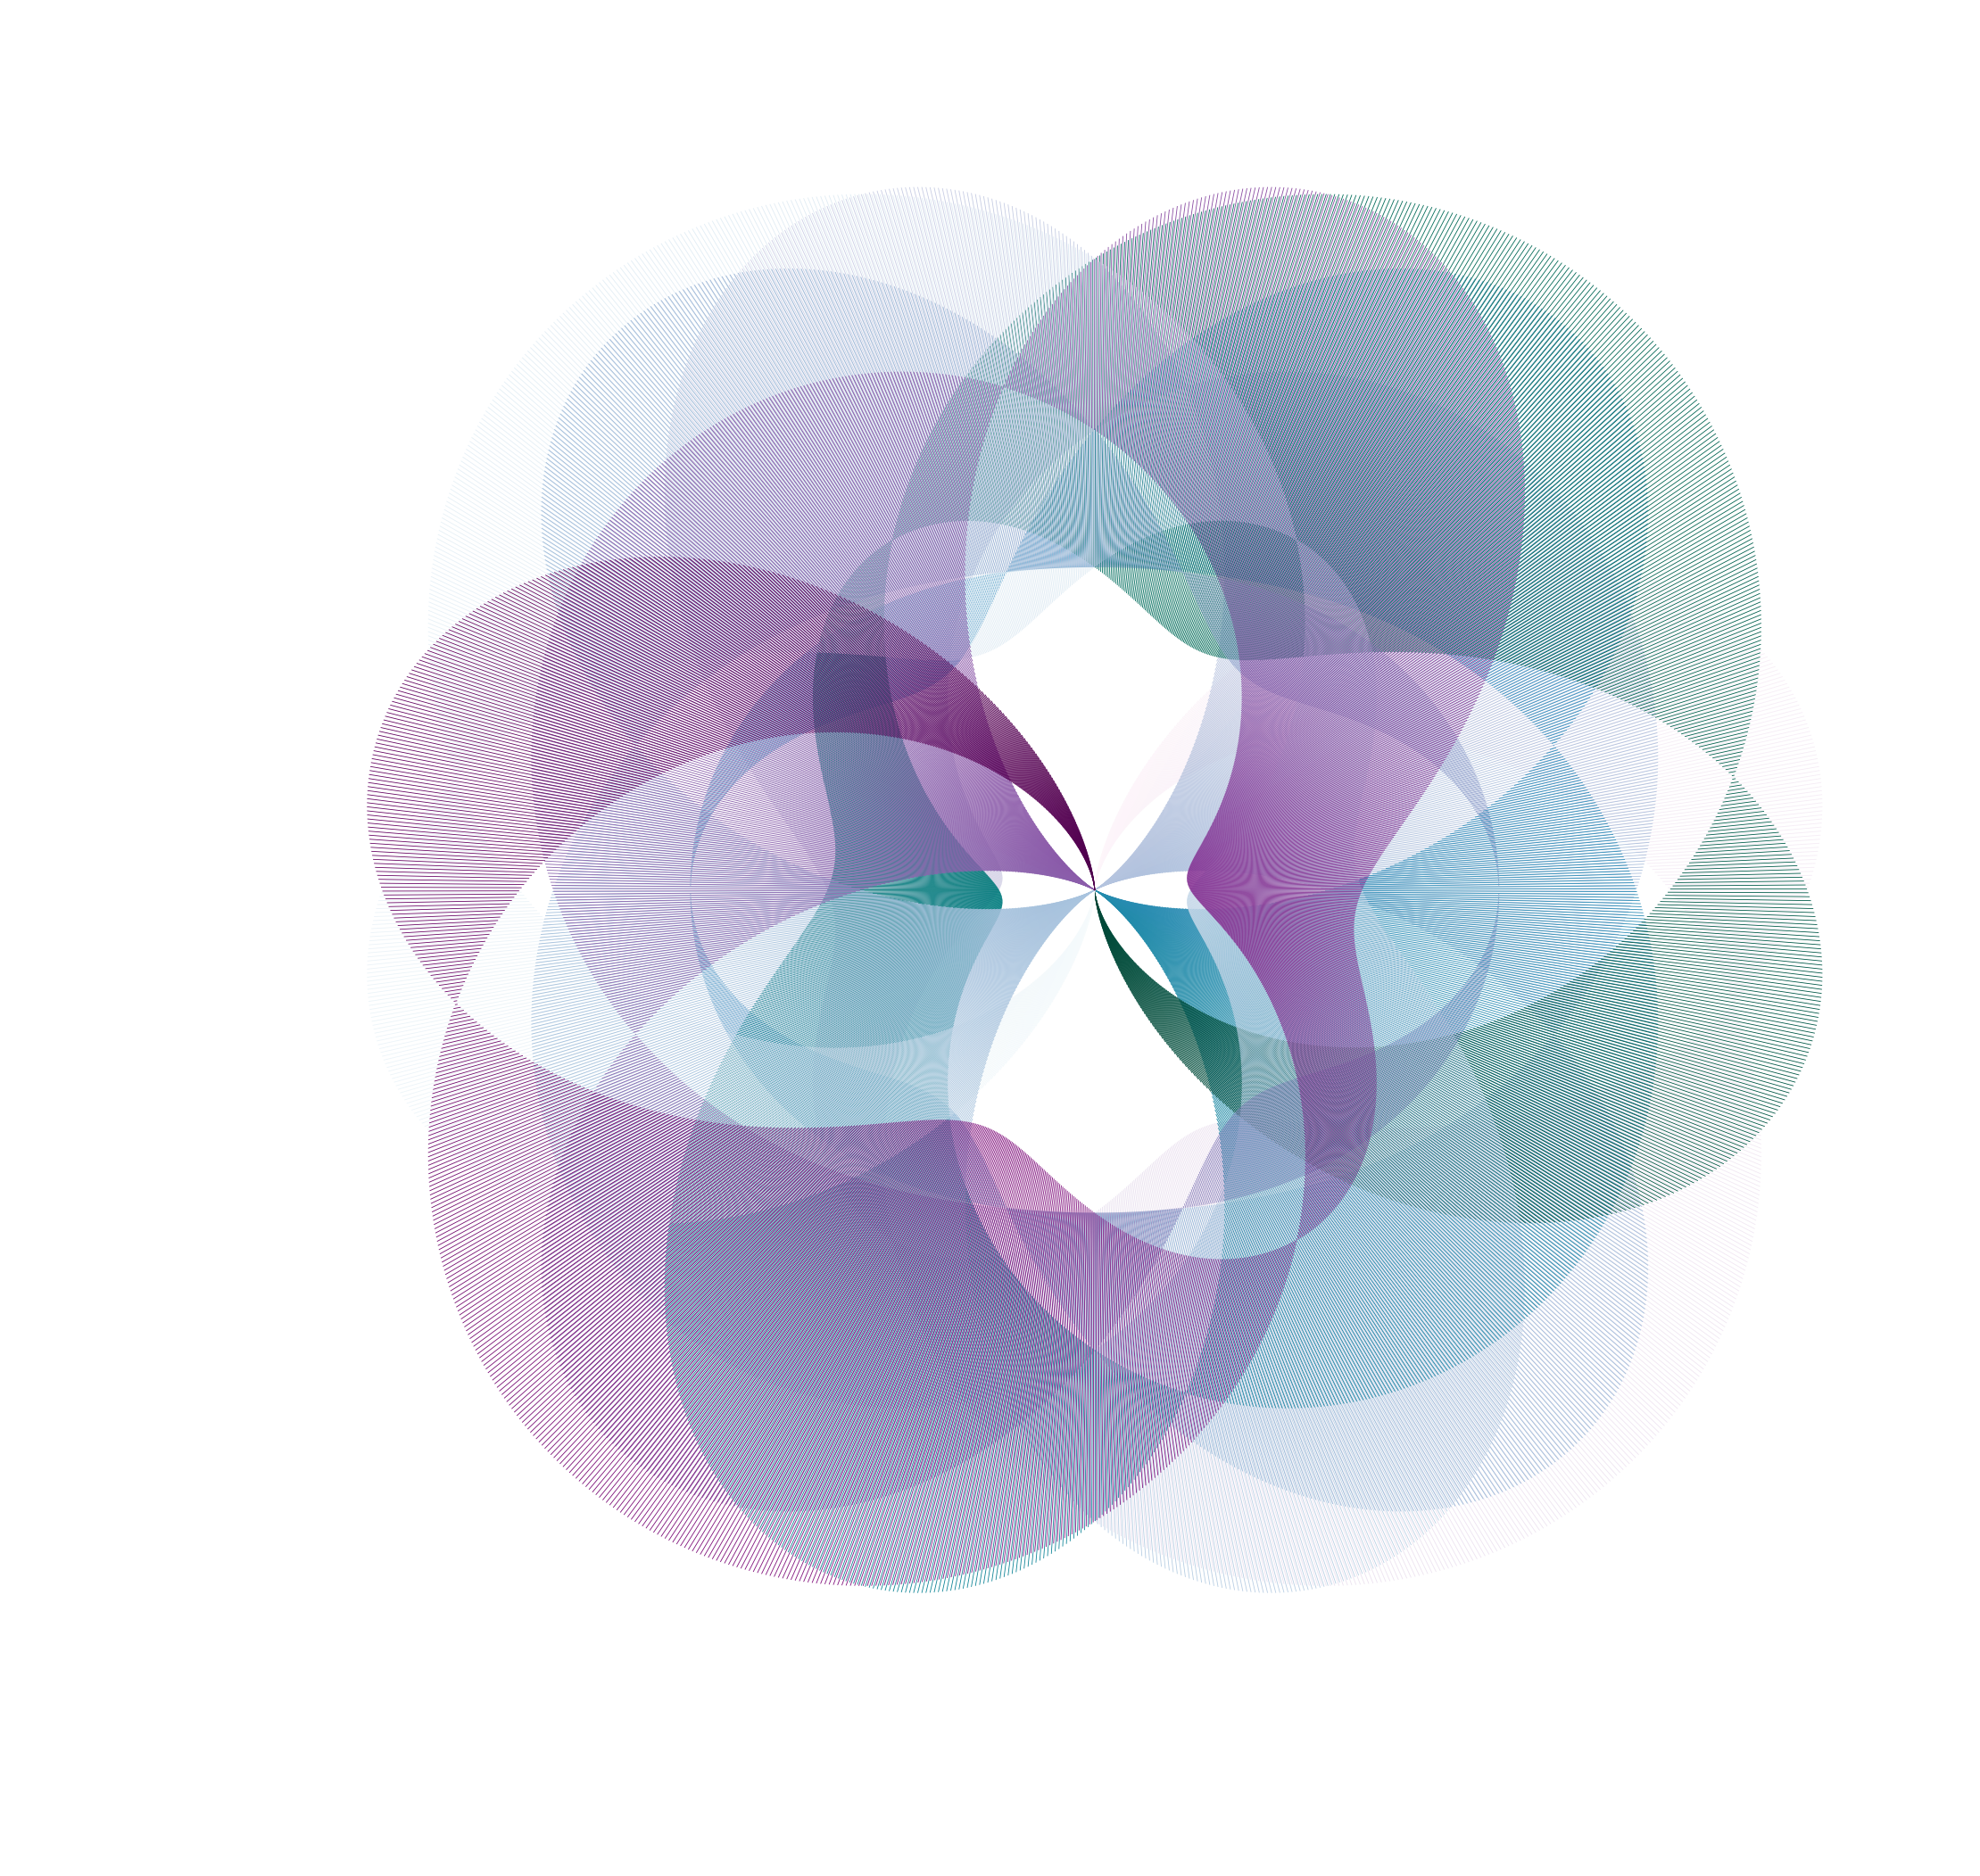

In [10]:
plot_values(); 

Although the run time for the overall function is incredibly long. The hardware carries out the computation very quickly. The run time to obtain all the values from the programmable logic is around 3 seconds, as demonstrated in the code below.

In [13]:
import time
start_time = time.time()
#Programmable Logic Speed Test
for i in range (1,8000):
    L,M,N,O = 0,0,0,0
    L,M,N,O = lines_8k.getValues(i)
end_time = time.time()   
duration = end_time - start_time
print("Function took", duration, "seconds to run.")

Function took 2.399034261703491 seconds to run.
